# Import

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

## Funções de suporte

In [2]:
def jupyter_settings():
    %matplotlib inline
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [15, 7]
    plt.rcParams['font.size'] = 16
    
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
jupyter_settings()

## Importar dados

In [3]:
df_raw = pd.read_csv('../data/raw/Ecommerce.csv', encoding = 'latin1')

In [4]:
df_raw.drop('Unnamed: 8', axis = 1, inplace = True)

# 1 Descrição dos dados

In [5]:
df1 = df_raw.copy()

## 1.1 Renomear colunas

In [6]:
cols = ['invoice', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'customer_id', 'country']
df1.columns = cols

In [7]:
df1.columns

Index(['invoice', 'stock_code', 'description', 'quantity', 'invoice_date',
       'unit_price', 'customer_id', 'country'],
      dtype='object')

**invoice:** Invoice number (A 6-digit integral number uniquely assigned to each transaction)

**stock_code:** Product (item) code

**description:** Product (item) name

**quantity:** The quantities of each product (item) per transaction

**invoice_date:** The day when each transaction was generated

**unit_price:** Unit price (Product price per unit)

**customer_id:** Customer number (Unique ID assigned to each customer)

**country:** Country name (The name of the country where each customer resides)

## 1.2 Dimensão dos dados

In [8]:
print('Número de linhas: {}'.format(df1.shape[0]))
print('Número de colunas: {}'.format(df1.shape[1]))

Número de linhas: 541909
Número de colunas: 8


## 1.3 Tipo dos dados

In [9]:
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format = '%d-%b-%y')

In [10]:
df1.dtypes

invoice                 object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
customer_id            float64
country                 object
dtype: object

## 1.4 Tratar os NAs

In [11]:
df1['description'].fillna('-', inplace = True)
df1.dropna(inplace = True)

In [12]:
df1.isna().sum()

invoice         0
stock_code      0
description     0
quantity        0
invoice_date    0
unit_price      0
customer_id     0
country         0
dtype: int64

## 1.5 Estatística descritiva

In [13]:
num_attributes = df1[['quantity', 'unit_price']]
cat_attributes = df1[['invoice', 'stock_code', 'customer_id', 'country']]

### 1.5.1 Atributos numéricos

In [14]:
# Tendência central - média, mediana
tc1 = pd.DataFrame(num_attributes.apply(np.mean)).T
tc2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersão - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(min)).T
d2 = pd.DataFrame(num_attributes.apply(max)).T
d3 = pd.DataFrame(num_attributes.apply(lambda x: x.max()-x.min())).T
d4 = pd.DataFrame(num_attributes.apply(np.std)).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# Contatenar
m = pd.concat([d1, d2, d3, tc1, tc2, d4, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,quantity,-80995.0,80995.0,161990.0,12.061303,5.00,248.693064,0.182663,94317.563673
1,unit_price,0.0,38970.0,38970.0,3.460471,1.95,69.315077,452.219019,246924.542988


### 1.5.2 Atributos categóricos

In [15]:
cat_attributes.apply(lambda x: len(x.unique()))

invoice        22190
stock_code      3684
customer_id     4372
country           37
dtype: int64

array([[<AxesSubplot:title={'center':'customer_id'}>]], dtype=object)

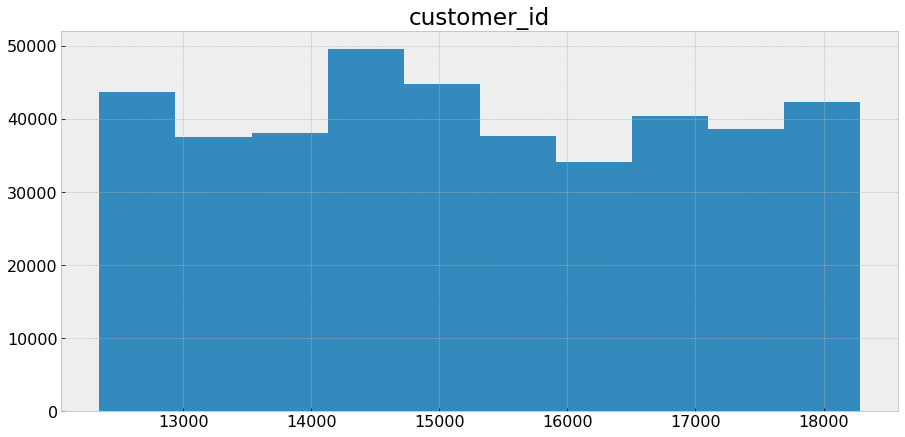

In [16]:
cat_attributes.hist()

<AxesSubplot:>

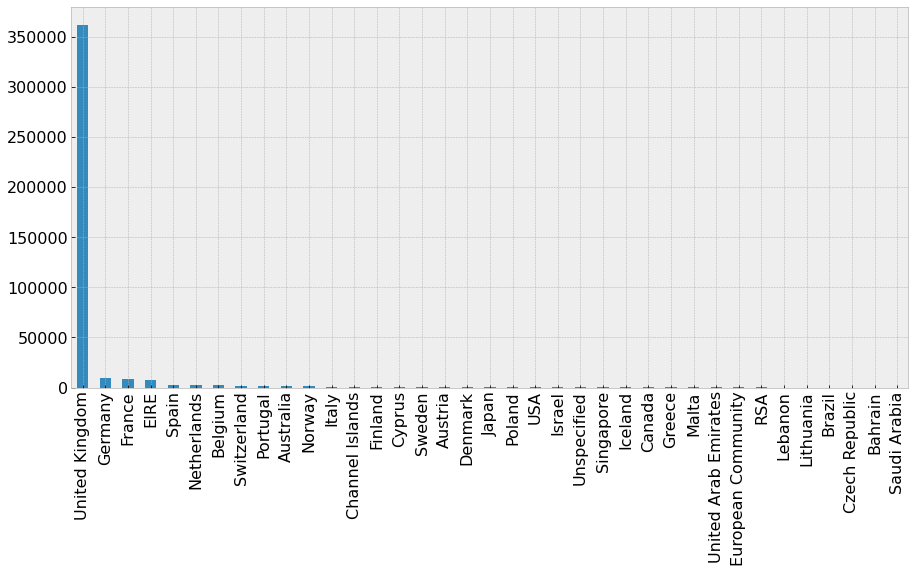

In [17]:
cat_attributes['country'].value_counts().plot(kind = 'bar')

<AxesSubplot:>

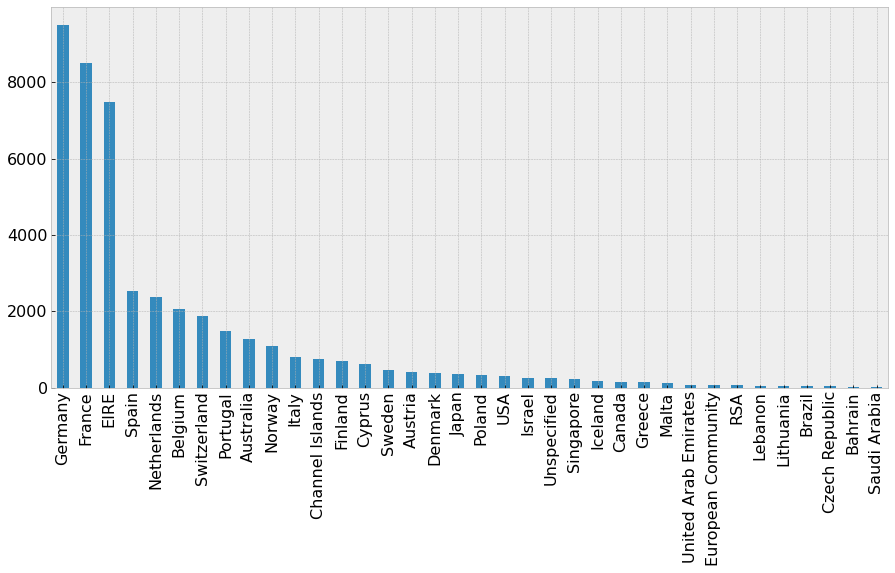

In [18]:
cat_attributes[cat_attributes['country'] != 'United Kingdom']['country'].value_counts().plot(kind = 'bar')

## 1.6 Outliers

In [24]:
# Invoices 541431 e 581483 parecem ser erros
customers = [16446, 12346]
df1[df1['customer_id'].isin(customers)]

,invoice,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2017-01-16,1.04,12346.0,United Kingdom
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2017-01-16,1.04,12346.0,United Kingdom
194354,553573,22980,PANTRY SCRUBBING BRUSH,1,2017-05-16,1.65,16446.0,United Kingdom
194355,553573,22982,PANTRY PASTRY BRUSH,1,2017-05-16,1.25,16446.0,United Kingdom
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2017-12-07,2.08,16446.0,United Kingdom
540422,C581484,23843,"PAPER CRAFT , LITTLE BIRDIE",-80995,2017-12-07,2.08,16446.0,United Kingdom


In [33]:
df1.drop([61619, 61624, 540421, 540422], inplace = True)

80995

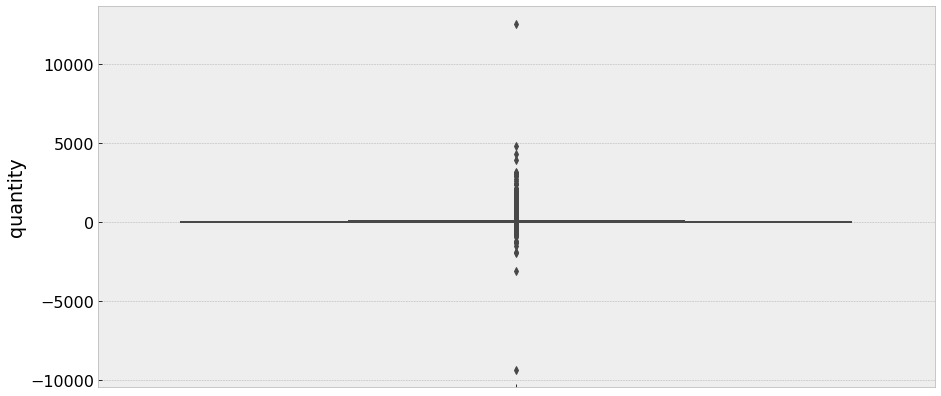

In [26]:
sns.boxplot(data = aux, y = 'quantity')
df1['quantity'].max()

# 2 Feature engineering

## Data checkpoint

In [34]:
df2 = df1.copy()

In [35]:
df2.to_csv('../data/interim/c1_df2.csv', index = False)

In [3]:
df2 = pd.read_csv('../data/interim/c1_df2.csv')
df2['invoice_date'] = pd.to_datetime(df2['invoice_date'])

## 2.1 Criação das variáveis

**customer_id:** customer identification

**volume:** total amount spend by customer so far

**recency:** time since last purchase

**frequency:** number of purchases

**low_purch:** lowest purchase value

**high_purch:** highest purchase value

**returns:** number of purchases where at least one product was returned

**mean_basket_size:** average number of items per purchase

**country:** customer's country of residence

In [36]:
# Total price
df2['price'] = df2['quantity']*df2['unit_price']

# customer_id, volume
df21 = df2[['customer_id', 'price']].groupby('customer_id').sum().reset_index().rename(columns = {'price': 'volume'})

# recency - days since last purchase
aux = df2[['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
df21 = df21.merge(aux, how = 'left', on = 'customer_id')
today = pd.to_datetime('today').date()
df21['recency'] = df21['invoice_date'].apply(lambda x: (today-x.date()).days)
df21 = df21[['customer_id', 'volume', 'recency']]

# frequency - number of purchases
aux = df2[['customer_id', 'invoice']].groupby('customer_id').nunique().reset_index().rename(columns = {'invoice': 'frequency'})
df21 = df21.merge(aux, how = 'left', on = 'customer_id')

# low_purch

# high_purch

# returns

# mean_basket_size

# country

In [37]:
df2 = df21.copy()

## 4.1 Análise univariada

# 3 Filtragem das variáveis

In [38]:
df3 = df2.copy()

# 4 Análise exploratória de dados

## Data checkpoint

In [39]:
df4 = df3.copy()

In [40]:
df4.to_csv('../data/interim/c1_df4.csv', index = False)

In [18]:
df4 = pd.read_csv('../data/interim/c1_df4.csv')

## 4.1 Análise univariada

### 4.1.1 Variáveis numéricas

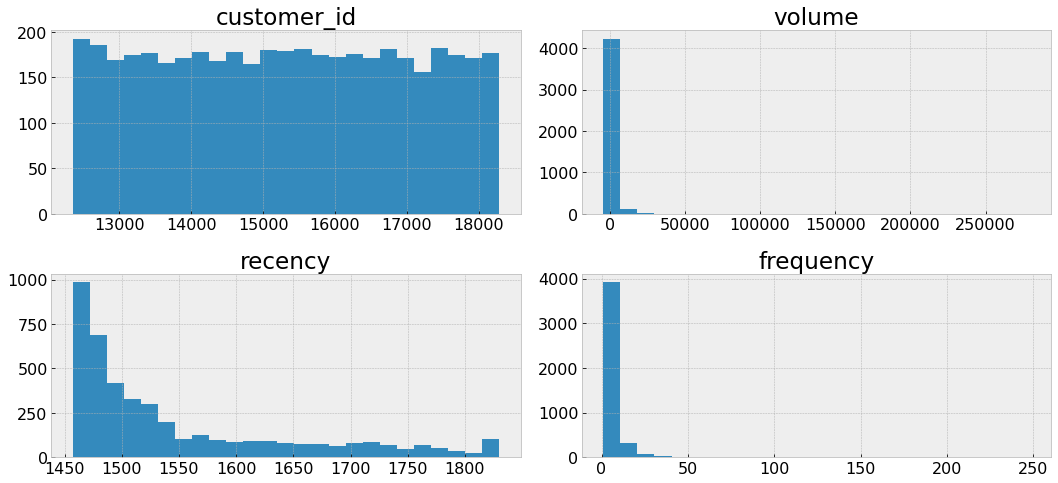

In [41]:
df4.hist(bins = 25);
plt.tight_layout()

<AxesSubplot:ylabel='frequency'>

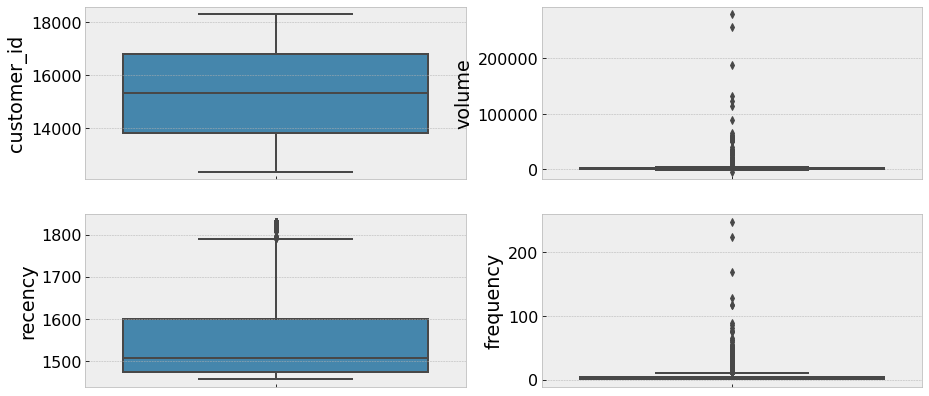

In [42]:
plt.subplot(2,2,1)
sns.boxplot(data = df4, y = 'customer_id')

plt.subplot(2,2,2)
sns.boxplot(data = df4, y = 'volume')

plt.subplot(2,2,3)
sns.boxplot(data = df4, y = 'recency')

plt.subplot(2,2,4)
sns.boxplot(data = df4, y = 'frequency')

## 4.2 Modelo RFM

In [101]:
df42 = df4.copy()

In [108]:
df42 = df42.sort_values('volume', ascending = False).reset_index(drop = True)
df42['m_score'] = 5-4*df42.index/len(df42)
# df42['m_score'] = df42['m_score'].apply(round)

df42 = df42.sort_values('recency').reset_index(drop = True)
df42['r_score'] = 5-4*df42.index/len(df42)
# df42['r_score'] = df42['r_score'].apply(round)

df42 = df42.sort_values('frequency', ascending = False).reset_index(drop = True)
df42['f_score'] = 5-4*df42.index/len(df42)
# df42['f_score'] = df42['f_score'].apply(round)

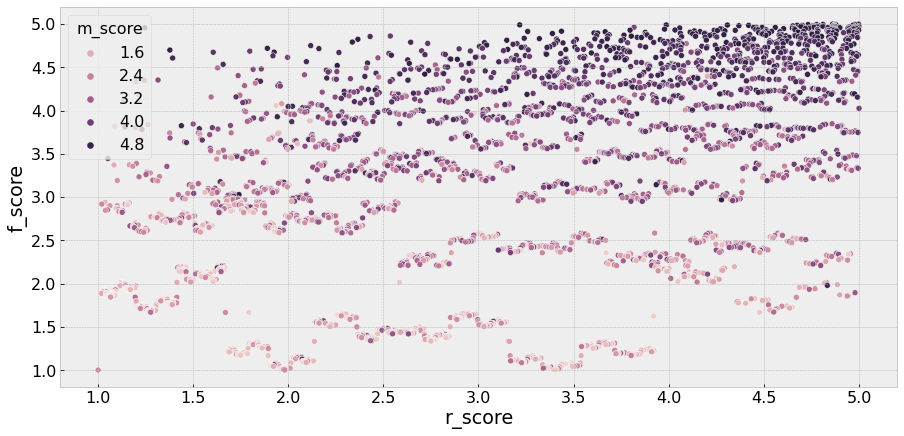

In [118]:
sns.scatterplot(data = df42, x = 'r_score', y = 'f_score', hue = 'm_score');